# Imports

In [2]:
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader

from datasets import ModelnetDataset, ShapenetDataset, JointDataset
from transforms import SetRotation
from vae import NPCVAE, AE
from modelutils import cd

# Prepare dataset

In [3]:
modelnet_train = ModelnetDataset(filter=1)
modelnet_test = ModelnetDataset(filter=1, test=True)
modelnet_train_loader = DataLoader(modelnet_train, batch_size=32, shuffle=True, num_workers=2)
modelnet_test_loader = DataLoader(modelnet_test, batch_size=32, shuffle=True, num_workers=2)

shapenet_train = ShapenetDataset(filter=1, transform=SetRotation((0, math.acos(0), 0)))
shapenet_test = ShapenetDataset(filter=1, test=True, transform=SetRotation((0, math.acos(0), 0)))
shapenet_train_loader = DataLoader(shapenet_train, batch_size=32, num_workers=2)
shapenet_test_loader = DataLoader(shapenet_test, batch_size=32, shuffle=True, num_workers=2)

joint_train = JointDataset(filter=1, transform_shapenet=SetRotation((0, math.acos(0), 0)))
joint_test = JointDataset(filter=1, test=True, transform_shapenet=SetRotation((0, math.acos(0), 0)))
joint_train_loader = DataLoader(joint_train, batch_size=32, shuffle=True, num_workers=2)
joint_test_loader = DataLoader(joint_test, batch_size=32, shuffle=True, num_workers=2)

print(len(joint_train))

3943


# Load model

In [ ]:
model = AE.load_from_drive(AE, name='ae')

In [4]:
model = NPCVAE.load_from_drive(NPCVAE, name='joint_pcvae')

# Visualize some reconstructions

In [9]:
def zzip(a, b):
    if len(a) == 0:
        if len(b) == 0:
            return []
        else:
            return b
    if len(b) == 0:
        return a
    return [a[0], b[0]] + zzip(a[1:], b[1:])

def unstack(t):
    return [x.squeeze(0) for x in list(t.split(1))]

In [14]:
def subplot_num(m, i, j):
    return i*m + j

def draw_pc(ax, pc):
    pc = SetRotation((np.pi/2, -np.pi, 0))(pc.detach().numpy())
    X, Y, Z = np.split(pc, 3)
    ax.scatter(X, Y, Z)

def plot_samples(samples, n, m, save=False, savename='pclouds'):
    fig = plt.figure(figsize=(4.5*m,4.5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = subplot_num(m, i, j)
            ax = fig.add_subplot(n, m, idx+1, projection='3d', xticks=[], yticks=[], zticks=[])
            draw_pc(ax, samples[idx])    
    if save:
        plt.savefig(savename, bbox_inches='tight', pad_inches=0)
    plt.show()

In [13]:
batch, _ = next(iter(modelnet_train_loader))
rec, _ = model(batch)
batch_rec = torch.stack(zzip(unstack(batch), unstack(rec)), dim=0).detach().numpy()
batch_rec.shape
dist = cd(batch, rec)
list(enumerate(list(dist)))

[(0, tensor(0.8198, grad_fn=<SelectBackward>)),
 (1, tensor(0.9391, grad_fn=<SelectBackward>)),
 (2, tensor(1.1202, grad_fn=<SelectBackward>)),
 (3, tensor(0.7523, grad_fn=<SelectBackward>)),
 (4, tensor(0.7794, grad_fn=<SelectBackward>)),
 (5, tensor(1.1350, grad_fn=<SelectBackward>)),
 (6, tensor(1.5397, grad_fn=<SelectBackward>)),
 (7, tensor(0.9241, grad_fn=<SelectBackward>)),
 (8, tensor(1.3354, grad_fn=<SelectBackward>)),
 (9, tensor(0.6369, grad_fn=<SelectBackward>)),
 (10, tensor(0.8338, grad_fn=<SelectBackward>)),
 (11, tensor(1.0377, grad_fn=<SelectBackward>)),
 (12, tensor(1.1441, grad_fn=<SelectBackward>)),
 (13, tensor(1.6341, grad_fn=<SelectBackward>)),
 (14, tensor(0.5593, grad_fn=<SelectBackward>)),
 (15, tensor(1.4050, grad_fn=<SelectBackward>)),
 (16, tensor(0.7736, grad_fn=<SelectBackward>)),
 (17, tensor(1.2135, grad_fn=<SelectBackward>)),
 (18, tensor(0.5078, grad_fn=<SelectBackward>)),
 (19, tensor(0.9446, grad_fn=<SelectBackward>)),
 (20, tensor(1.1217, grad_fn=<

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


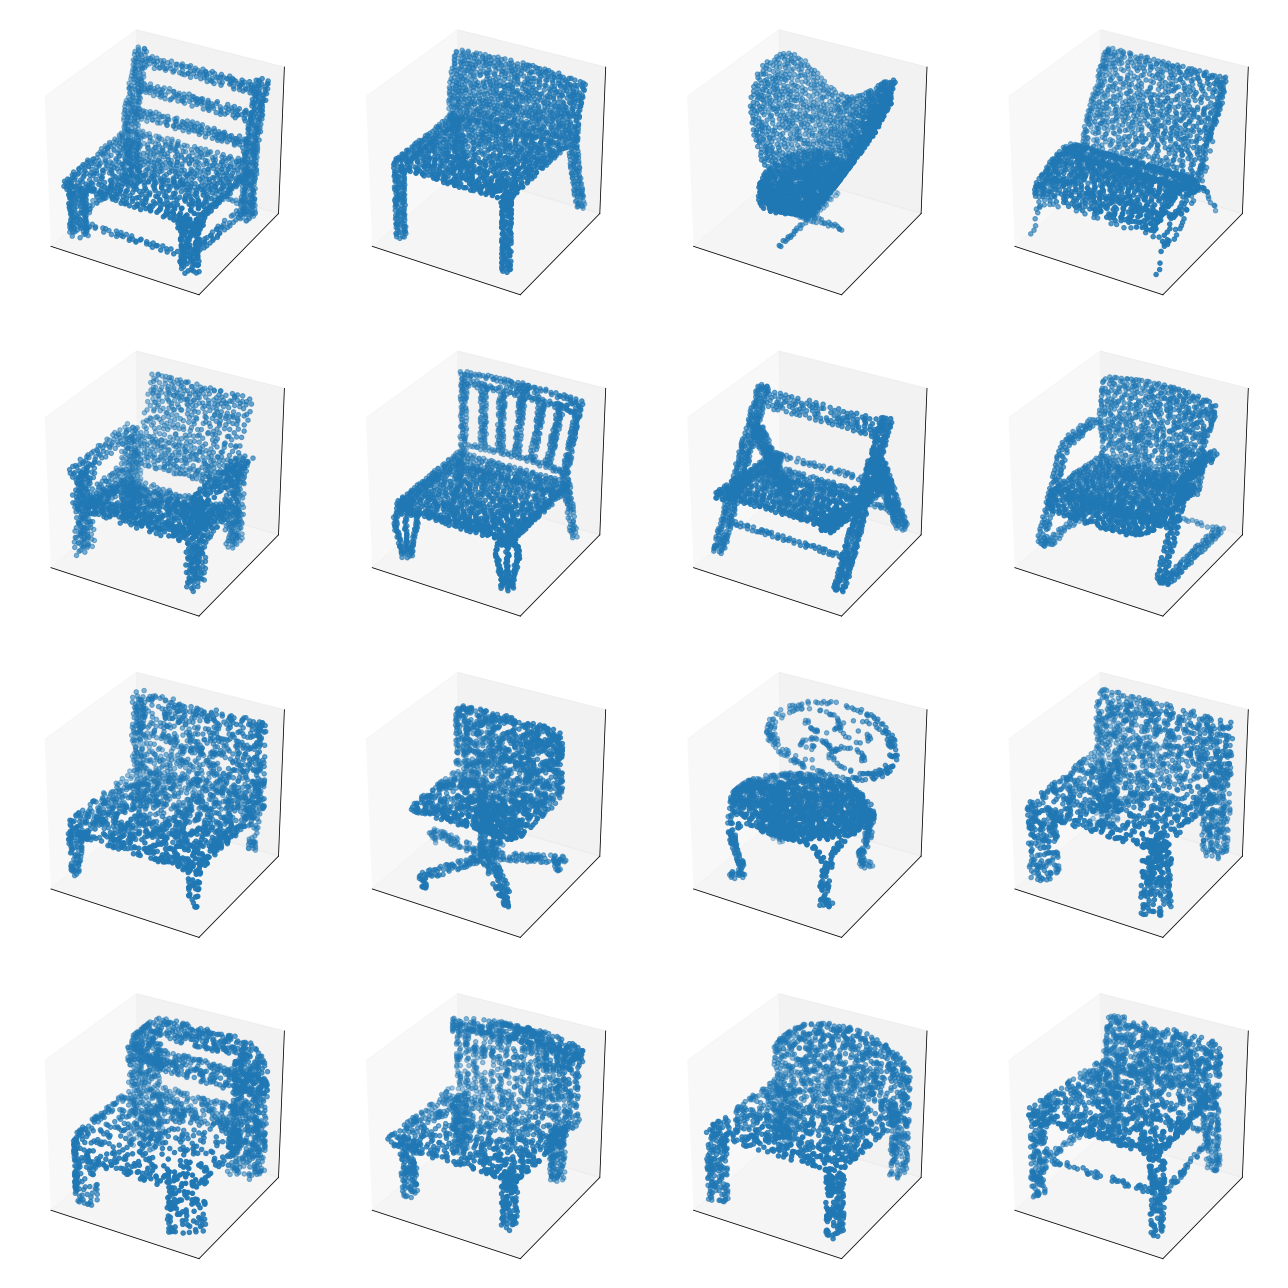

In [20]:
plot_samples(batch_rec, 4, 4)

# Interpolation

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


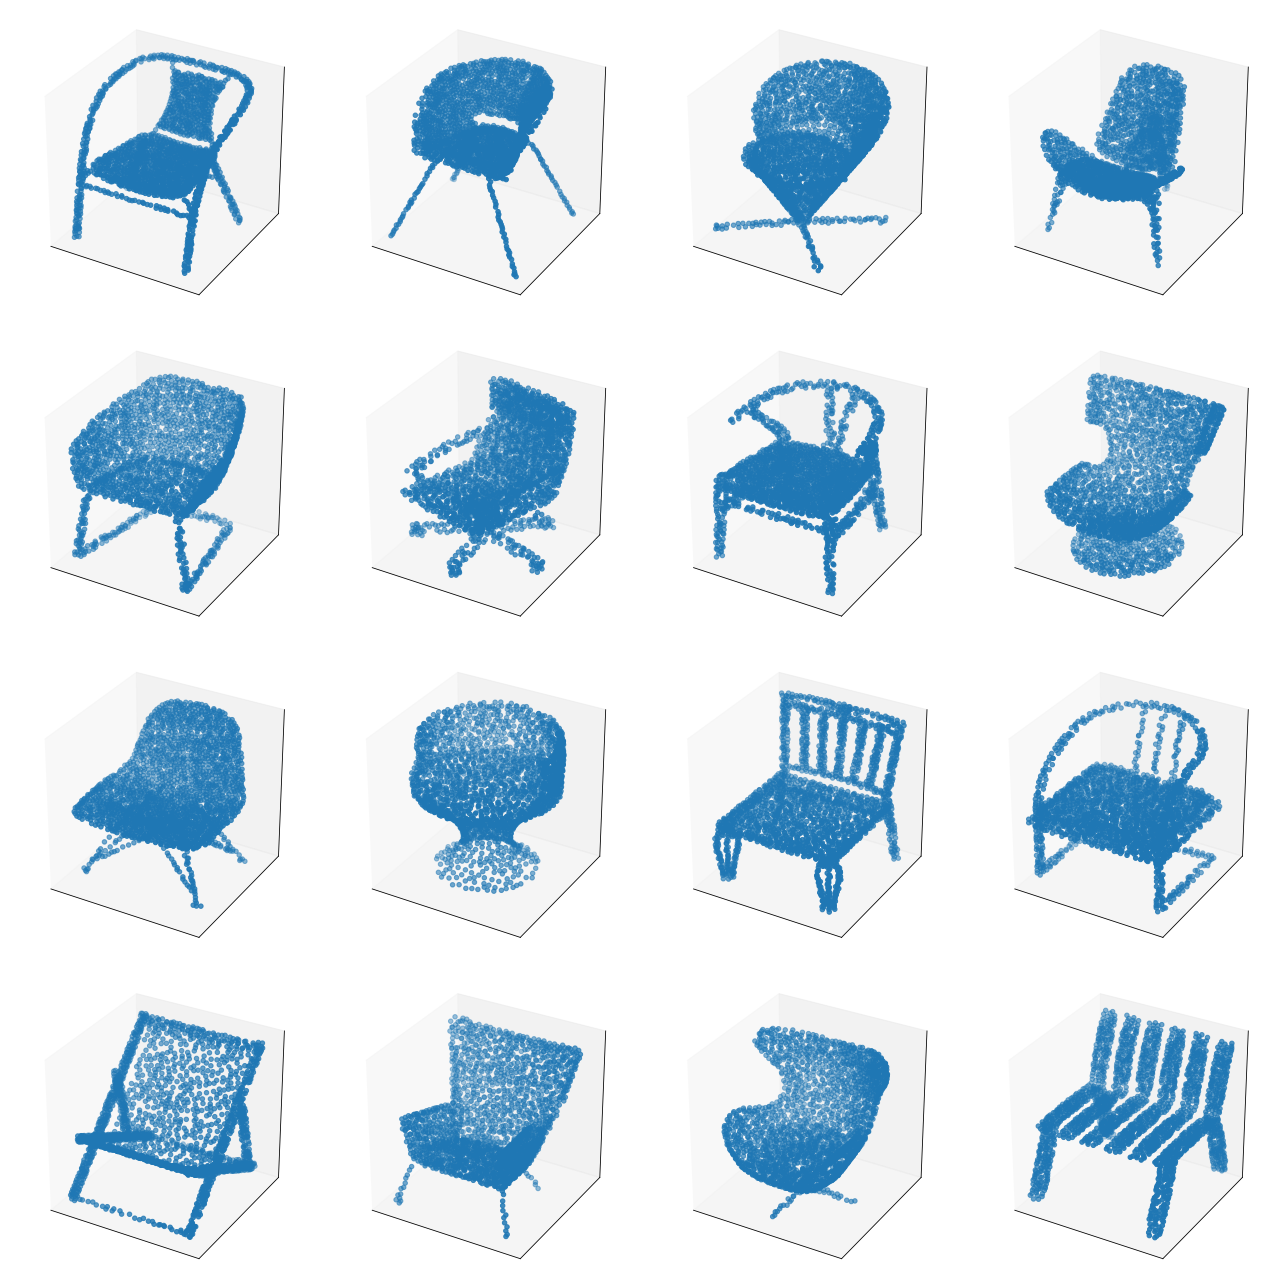

In [21]:
fancy_objects = torch.tensor(np.load('fancy_objects.npy'))
plot_samples(fancy_objects, 4, 4)

In [76]:
num_steps = 36

sources = [1]
targets = [12]

all_steps = []

for idx in range(len(sources)):
    source = fancy_objects[sources[idx]]
    target = fancy_objects[targets[idx]]
    (source_latent, target_latent) = model.encoder(torch.stack([source, target], dim=0))
    steps = ([source_latent] + 
            [source_latent + x*(target_latent-source_latent) for x in torch.linspace(0.35, 0.8, steps=num_steps-2)] + 
            [target_latent])
    latent_steps = torch.stack(steps, dim=0)
    interpolation_steps = model.decoder(latent_steps).reshape((-1,)+source.shape).detach()
    all_steps.append(interpolation_steps)
    
all_steps = torch.cat(all_steps, dim=0)

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


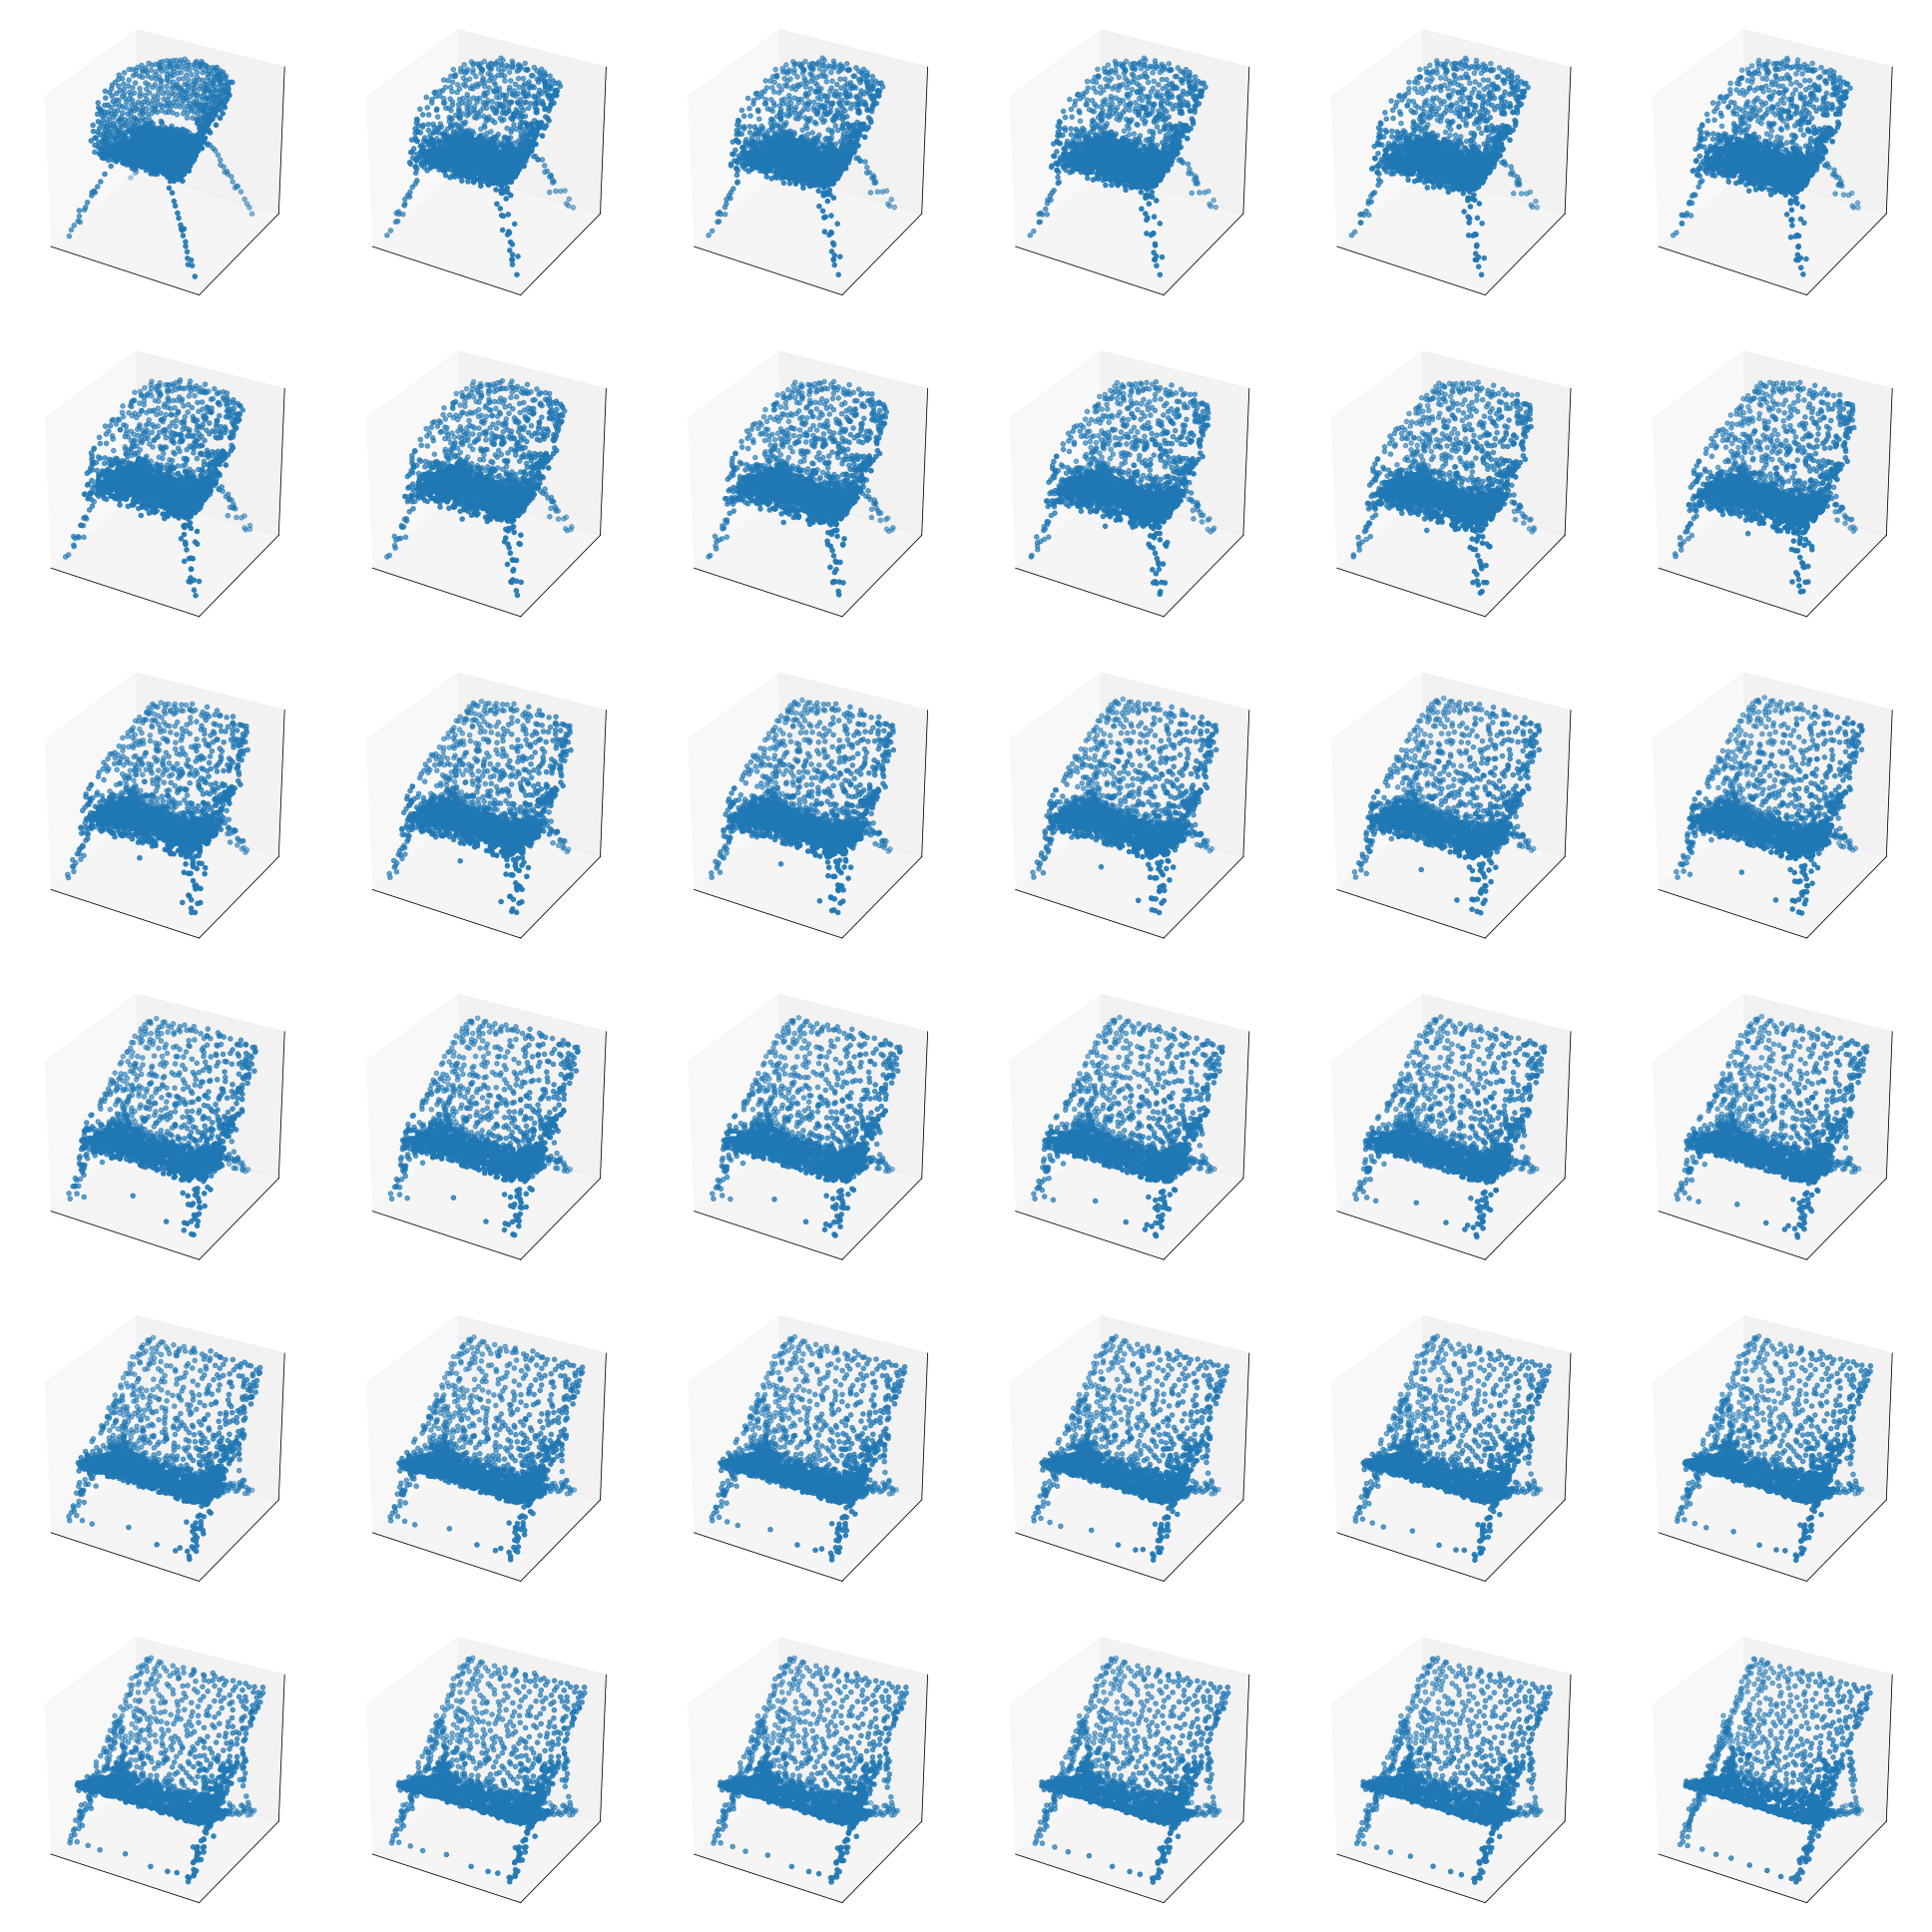

In [77]:
plot_samples(all_steps, 6, 6)

# Latent arithmetic

In [32]:
samples = torch.tensor(np.load('nice_arithmetic.npy'))

In [33]:
latents = model.encoder(samples)
all_samples = []
for i in range(0, len(samples), 3):
    a, b, c = samples[i:i+3]
    al, bl, cl = latents[i:i+3]
    dl = al-bl+cl
    d = model.decoder(dl.unsqueeze(0)).detach().reshape((-1,)+samples[0].shape)[0]
    all_samples += [a, b, c, d]
joint = torch.stack(all_samples, dim=0)

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


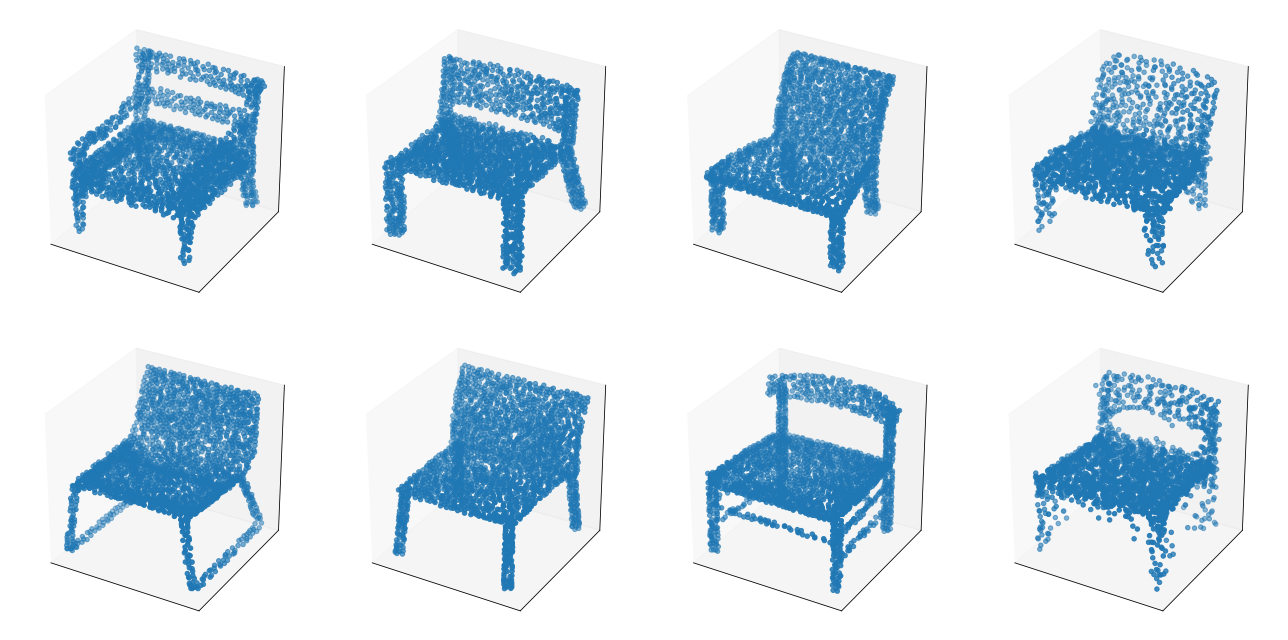

In [34]:
plot_samples(joint, 2, 4)

# Losowanie latentu

In [43]:
num_samples = 32

sample_shape = batch[0].shape
means = model.encoder(batch)
latent = means.shape[1]
z = 1.0*torch.randn(num_samples, latent)

In [44]:
rec = model.decoder(z).reshape((num_samples,)+sample_shape).detach()

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


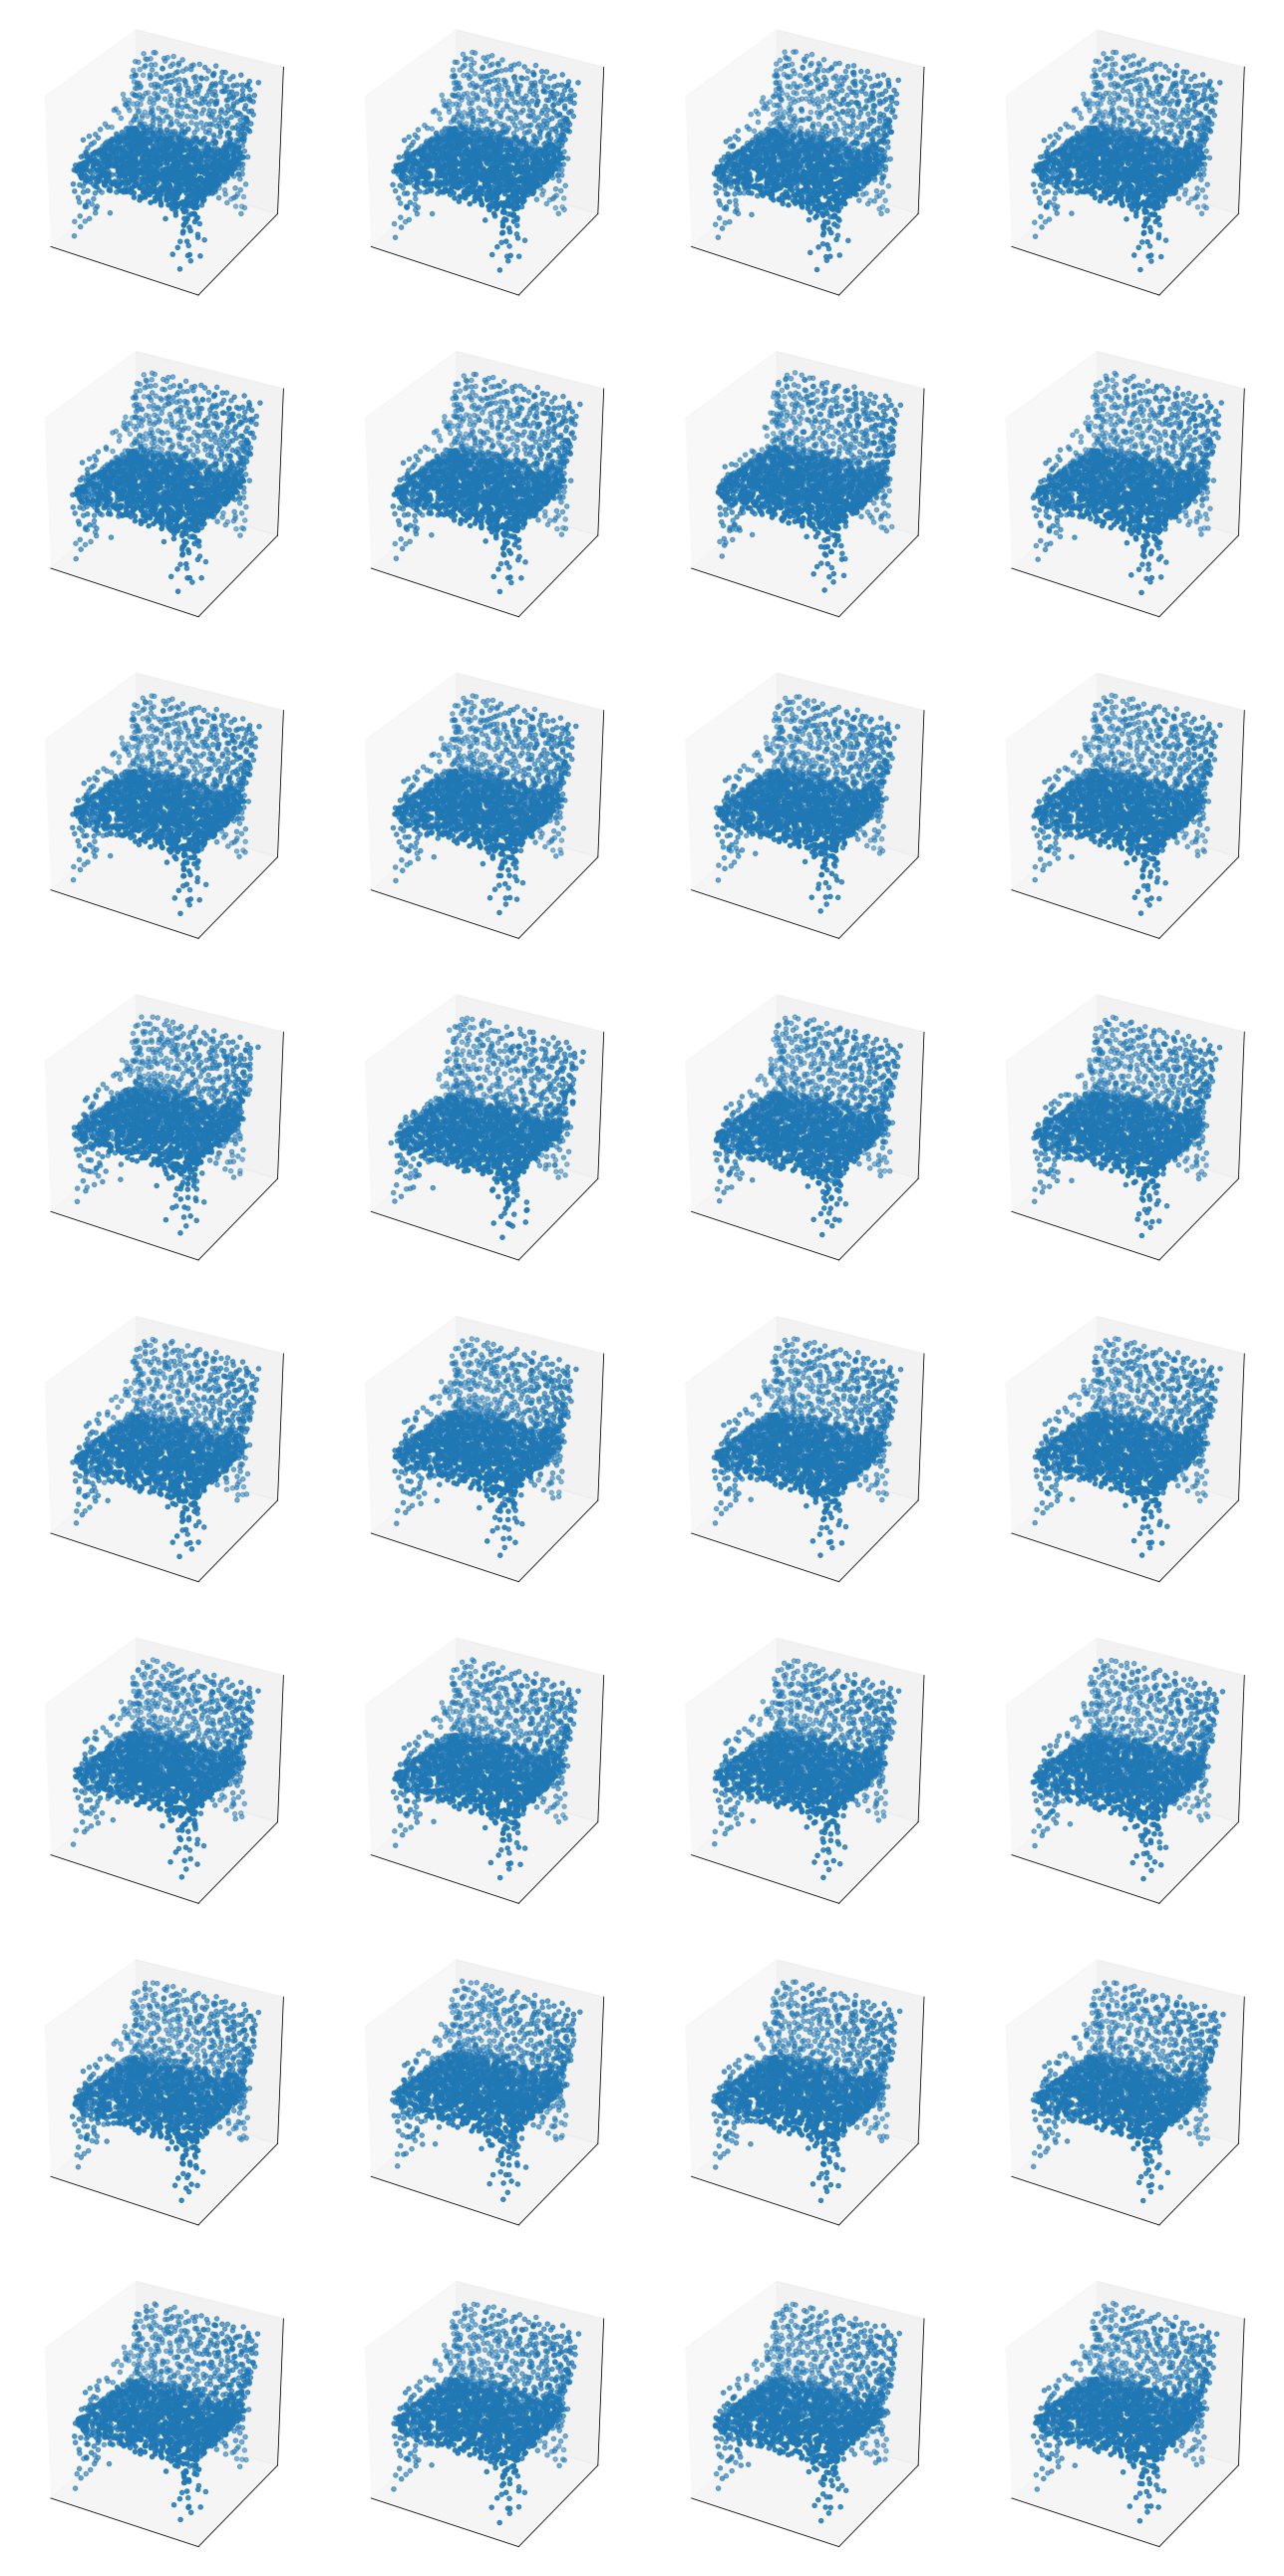

In [45]:
plot_samples(rec, 8, 4)

# Wykresy tSNE

In [189]:
with torch.no_grad():
    latents_list = [model.encode(x)[0] for x, _ in shapenet_train_loader]
latents = torch.cat(latents_list, dim=0).detach().numpy()

In [226]:
tsne = TSNE(n_components=2)
X, Y = tsne.fit_transform(latents).T

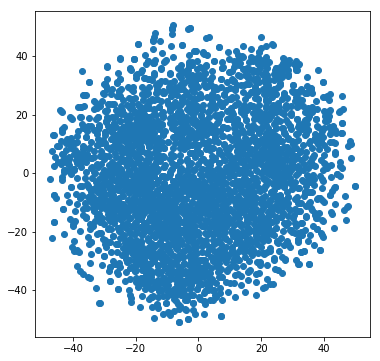

In [227]:
plt.figure(figsize=(6, 6))
# plt.axis('off')
plt.scatter(X, Y)
# plt.savefig('vae_means_tsne', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
fx, tx = -20, -5
fy, ty = -45, -35
idxs = list(filter(lambda idx: X[idx] > fx and X[idx] < tx and Y[idx] > fy and Y[idx] < ty, range(X.shape[0])))
XY = np.stack((X, Y), axis=1)
XY[idxs]
selected_latents = torch.tensor(np.stack([latents[idxs[idx]] for idx in range(len(idxs))], axis=0))
selected_samples = model.decoder(selected_latents).reshape((-1,3,2048)).detach()

In [ ]:
plot_samples(selected_samples, 4, 4)

# Loss on loader

In [6]:
def loss_on_loader(model, loader, binarize=False):
    total = 0
    batches = 0
    with torch.no_grad():
        for x, _ in loader:
            batches += 1
            rec, _ = model(x)
            mcd = torch.mean(cd(x, rec))
            total += mcd
            print(batches, mcd)
    return total / batches

In [7]:
loss_on_loader(model, joint_loader)

1 tensor(0.9700)
2 tensor(0.8281)
3 tensor(0.8548)
4 tensor(0.8503)
5 tensor(0.9057)
6 tensor(0.7652)
7 tensor(0.8696)
8 tensor(0.8970)
9 tensor(0.8199)
10 tensor(0.8660)
11 tensor(0.8577)
12 tensor(0.7967)
13 tensor(0.9114)
14 tensor(0.9050)
15 tensor(0.7684)
16 tensor(0.8057)
17 tensor(0.9415)
18 tensor(0.9344)
19 tensor(0.7781)
20 tensor(0.7647)
21 tensor(0.7901)
22 tensor(0.9424)
23 tensor(0.7857)
24 tensor(0.8613)
25 tensor(0.8452)
26 tensor(0.8273)
27 tensor(0.7049)
28 tensor(0.8405)
29 tensor(0.8078)
30 tensor(0.9890)
31 tensor(0.8355)
32 tensor(0.7595)
33 tensor(0.9055)
34 tensor(0.7684)
35 tensor(0.8810)
36 tensor(0.9086)
37 tensor(0.9026)
38 tensor(0.8674)
39 tensor(0.8872)
40 tensor(0.8333)
41 tensor(0.8588)
42 tensor(0.8027)
43 tensor(0.8225)
44 tensor(0.7603)
45 tensor(0.9131)
46 tensor(0.8519)
47 tensor(0.7956)
48 tensor(0.7734)
49 tensor(0.8674)
50 tensor(0.8331)
51 tensor(0.9208)
52 tensor(0.8070)
53 tensor(0.8711)
54 tensor(0.8113)
55 tensor(0.8275)
56 tensor(0.8572)
5

tensor(0.8497)

In [10]:
loss_on_loader(model, joint_test_loader)

1 tensor(0.8136)
2 tensor(0.8302)
3 tensor(1.0134)
4 tensor(1.5913)
5 tensor(0.7909)
6 tensor(1.2927)
7 tensor(0.9736)
8 tensor(1.0689)
9 tensor(0.8067)
10 tensor(1.3432)
11 tensor(1.3493)
12 tensor(1.3989)
13 tensor(0.7944)
14 tensor(1.1066)
15 tensor(0.9573)
16 tensor(1.3295)
17 tensor(1.1421)
18 tensor(1.3433)
19 tensor(0.9047)
20 tensor(0.7936)
21 tensor(0.8447)
22 tensor(0.8742)
23 tensor(1.6714)
24 tensor(0.9881)
25 tensor(0.8739)
26 tensor(0.7614)
27 tensor(0.8502)
28 tensor(1.1392)
29 tensor(1.7882)
30 tensor(1.7681)
31 tensor(1.3160)
32 tensor(1.0574)
33 tensor(1.0961)
34 tensor(0.8199)
35 tensor(0.9116)
36 tensor(1.4405)
37 tensor(1.2406)
38 tensor(1.0437)
39 tensor(1.0249)
40 tensor(0.8031)
41 tensor(1.0120)
42 tensor(1.0336)
43 tensor(1.8777)
44 tensor(0.8500)
45 tensor(1.1119)


tensor(1.1076)

# Loss decrease plot

In [ ]:
logs = np.load('train_logs.npy')
x = np.arange(1, 3002, step=5)
x[-1] = 2999

plt.figure(figsize=(10,5), dpi=200)
plt.plot(x, logs[0], label='total train')
plt.plot(x, logs[1], label='total test')
plt.plot(x, logs[2], label='rec train')
# plt.plot(x, logs[3], label='KL')
plt.plot(x, logs[4], label='rec test')
plt.xlim((0,2500))
plt.ylim((600,2000))
plt.legend()
# plt.savefig('total_loss_decrease', bbox_inches='tight', padding=0)
plt.show()

# Coverage

In [29]:
recs_list = []
with torch.no_grad():
    for x, _ in test_loader:
        rec, _ = model(batch)
        recs_list.append(rec)
recs = torch.cat(recs_list, dim=0)

In [40]:
def nearest(sample, loader):
    best = float('inf')
    sample = sample.unsqueeze(0)
    with torch.no_grad():
        for x, _ in loader:
            y = sample.expand(x.shape[0], -1, -1)
            d = cd(x, y)
            d[d < 1e-4] += float('inf')
            best = min(best, torch.min(d).item())
    print(best)
    return best

def nearest_for_each(source_loader, target_loader):
    nearest_list = []
    with torch.no_grad():
        for x, _ in source_loader:
            nearest_list += [nearest(x[idx], target_loader) for idx in range(x.shape[0])]
    return torch.cat(nearest_list, dim=0)

In [ ]:
recs_dataset = FromNpDataset(recs, np.zeros(recs.shape[0]))
recs_loader = DataLoader(recs_dataset, batch_size=32, shuffle=False, num_workers=2)

orig_to_orig = nearest_for_each(test_loader, test_loader)
orig_to_rec = nearest_for_each(test_loader, recs_loader)

float(torch.sum(orig_to_rec < orig_to_orig) / recs.shape[0])